In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
x = pd.read_csv('parkinsons_updrs.csv')
features = x.columns  # first columns will contain the names of the features
print(f'Dataset size = {x.shape}')
print(f'Dataset features count = {len(features)}')
# print(features)

Dataset size = (5875, 22)
Dataset features count = 22


Features list:
- subject#: patient number
- age: age of the patient
- sex: sex of the patient
- test_time: period from the beginning of the measurement (integer -> day, float -> hour from 0AM to 12PM)
- motor_UPDRS:
- total_UPDRS:
Jitter, in general, is the variation of the fundamental frequency in signals that should be periodic but are not
- Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP
Shimmer, in general, is the variation of amplitude in signals that should be periodic but are not
- Shimmer, Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, Shipper:APQ11, Shimmer:DDA
- NHR: Noise to Harmonics Ratio
- HNR: Harmonic to Noise Ratio
- RPDE: Recurrence Period Density Entropy
- DFA: Detrended Fluctuation Analysis
- PPE: Perceived Vocal Effort is the measure of effort (physical and cognitive) used to produce speech

<Axes: ylabel='Frequency'>

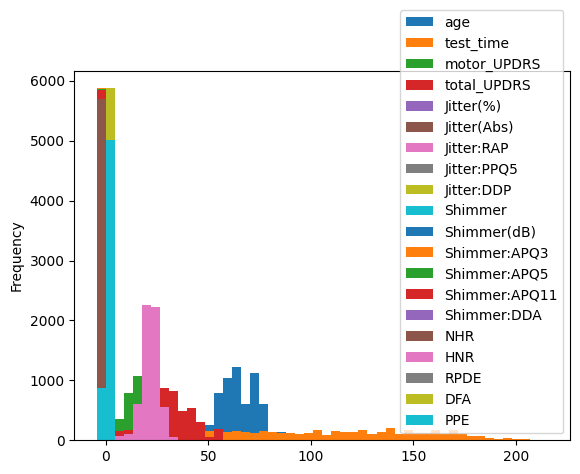

In [3]:
# print(pd.unique(x['subject#']))
# x.plot.scatter('subject#', 'age')
x.loc[:, ~x.columns.isin(['subject#', 'sex'])].plot.hist(
    bins=50)  # 'subject#' and 'sex' are removed to have a clearer histogram
# bins is the number of rectangles, so the lesser -> the more values will be represented with a single rectangle

In [4]:
X = pd.DataFrame()
subj = np.unique(x['subject#'])
for k in subj:  # for each subject#
    xk = x[x['subject#'] == k]
    xk1 = xk.copy()
    xk1.test_time = xk1.test_time.astype(int)
    xk1['g'] = xk1['test_time']  # new property called 'g' containing the 'test_time' property
    # now the dataframe collapses using 'g' as pivot, and computing the mean for each other property
    v = xk1.groupby('g').mean()
    X = pd.concat([X, v], axis=0, ignore_index=True)  # axis=0 -> concatenation along rows. (0, 1) -> (rows, columns)
features = x.columns
Np, Nc = X.shape
print(f'X shape = {X.shape}')

X shape = (990, 22)


In [5]:
Xnorm = (X - X.mean()) / X.std()
c = Xnorm.cov()

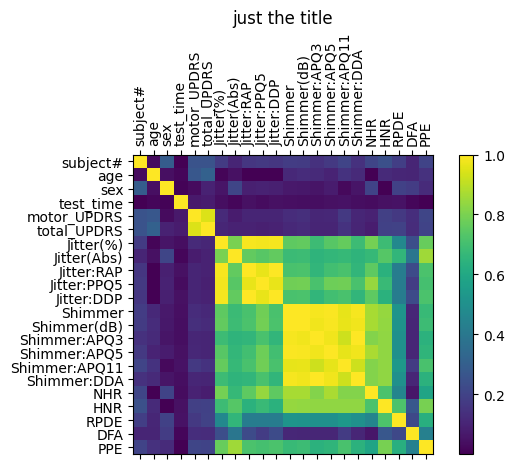

In [6]:
plt.figure()
plt.matshow(np.abs(c.values), fignum=0)
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)
plt.colorbar()
plt.title('just the title')
plt.tight_layout()
plt.savefig('./corr_coeff.png')
plt.show()

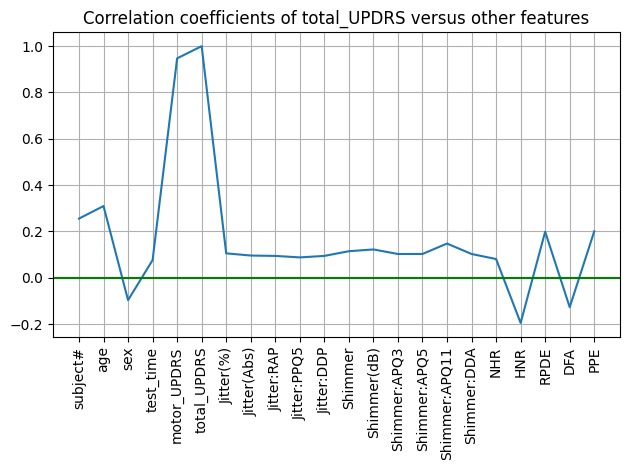

In [7]:
plt.figure()
c.total_UPDRS.plot()
plt.grid()
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.axhline(y=0, color='g')
plt.title('Correlation coefficients of total_UPDRS versus other features')
plt.tight_layout()
plt.show()

In [8]:
seed = 319244
Xsh = X.sample(frac=1, replace=False, random_state=seed, axis=0, ignore_index=True)

In [9]:
# Percentages
percent_training = 0.5
percent_test = 0.25
percent_validation = 1 - percent_training - percent_test

In [10]:
Ntr = int(Np * percent_training)  # Number of training points
Nte = int(Np * percent_test)  # Number of test points
Nva = Np - Ntr - Nte

X_tr = Xsh[:Ntr]

mm = X_tr.mean()
ss = X_tr.std()
my = mm['total_UPDRS']
sy = ss['total_UPDRS']
mm_vals = mm.values
ss_vals = ss.values

In [11]:
Xsh_norm = (Xsh - mm_vals) / ss_vals  # normalization of all parameters
ysh_norm = Xsh_norm['total_UPDRS']  # total_UPDRS will be the regressand
Xsh_norm = Xsh_norm[['motor_UPDRS', 'age', 'PPE']]  # keeping only these three regressors
# Xsh_norm = Xsh_norm.drop(['total_UPDRS', 'subject#', 'test_time'], axis=1)  # removing the regressand and other useless
# or known correlated features

X_tr_norm = Xsh_norm[:Ntr].values
X_va_norm = Xsh_norm[Ntr:Ntr + Nva].values
X_te_norm = Xsh_norm[-Nte:].values
y_tr_norm = ysh_norm[:Ntr].values
y_va_norm = ysh_norm[Ntr:Ntr + Nva].values
y_te_norm = ysh_norm[-Nte:].values

In [12]:
# Useful functions
def eucl_distance(v1, v2):
    assert len(v1) == len(v2)
    v_diff = v1 - v2
    return pow(v_diff.T @ v_diff, 0.5)


def e_MSE(y, y_hat):
    assert len(y) == len(y_hat)
    Ndataset = len(y)
    return sum((y[i] - y_hat[i]) ** 2 for i in range(Ndataset)) / Ndataset


def GPR(X_tr, y_tr, X_te, y_te, r2, s2, N):
    Ntr = len(y_tr)
    Nte = len(y_te)
    y_hat = np.empty(Nte)
    variance = 0
    for row in range(Nte):
        x = X_te[row]
        distances = [eucl_distance(x, X_tr[i]) for i in range(Ntr)]
        i_order = np.argsort(distances)
        closer_X = np.array([X_tr[i] for i in i_order[:N - 1]])
        closer_y = np.array([y_tr[i] for i in i_order[:N - 1]])
        Xr = np.concatenate((closer_X, [x]), axis=0)
        Rn = np.empty(shape=(N, N))
        for n in range(N):
            for k in range(N):
                Rn[n, k] = t * np.exp(- (np.linalg.norm(Xr[n] - Xr[k]) ** 2) / (2 * r2))
                if n == k:
                    Rn[n, k] = Rn[n, k] + s2 ** 2
        k = Rn[-1, :N - 1]
        d = Rn[-1, -1]
        Rn_sub_inv = np.linalg.inv(Rn[:N - 1, :N - 1])
        y_hat[row] = k.T @ Rn_sub_inv @ closer_y
        variance = d - k.T @ Rn_sub_inv @ k
    return {'y_hat': y_hat, 'variance': variance}

In [13]:
# Solver control plane
r2 = 100
t = 1
s2 = 0.001
N = 10

In [14]:
y_hat_norm = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm,
                 X_te=X_va_norm, y_te=y_va_norm,
                 r2=r2, s2=s2, N=N)['y_hat']

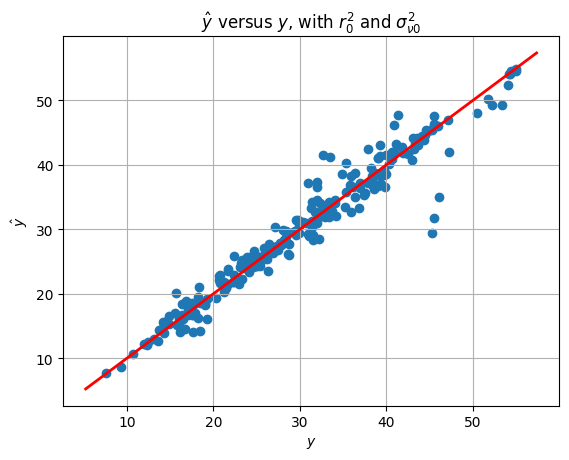

In [15]:
y_hat = y_hat_norm * sy + my
y_va = y_va_norm * sy + my
plt.figure()
plt.scatter(y_va, y_hat)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$, with $r_0^2$ and $\\sigma_{\\nu 0}^2$')
plt.grid()
plt.show()

In [16]:
# Grid search section
r2_best = r2
s2_best = s2
N_best = N

In [17]:
# Grid search for r2
Nr2 = 100
r2_range = np.linspace(10, 1000, Nr2)
errors_r2 = np.empty(Nr2)
y_hat_norm_r2 = np.empty(Nva)
for i in range(Nr2):
    r2 = r2_range[i]
    y_hat_norm_r2 = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm,
                        X_te=X_va_norm, y_te=y_va_norm,
                        r2=r2, s2=s2_best, N=N_best)['y_hat']
    errors_r2[i] = e_MSE(y_va_norm, y_hat_norm_r2)
r2_best = r2_range[np.argmin(errors_r2)]
print(f'Best r2 found (e_MSE = {min(errors_r2)}): {r2_best}')

Best r2 found (e_MSE = 0.05223935641025649): 90.0


In [18]:
# Grid search for s2
Ns2 = 100
s2_range = np.linspace(0.0001, 0.01, Ns2)
errors_s2 = np.empty(Ns2)
y_hat_norm_s2 = np.empty(Nva)
for i in range(Ns2):
    s2 = s2_range[i]
    y_hat_norm_s2 = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm,
                        X_te=X_va_norm, y_te=y_va_norm,
                        r2=r2_best, s2=s2, N=N_best)['y_hat']
    errors_s2[i] = e_MSE(y_va_norm, y_hat_norm_s2)
s2_best = s2_range[np.argmin(errors_s2)]
print(f'Best s2 found (e_MSE = {min(errors_s2)}): {s2_best}')

Best s2 found (e_MSE = 0.05223710530398424): 0.0011


In [19]:
# Result with best r2 and s2
y_hat_norm_r2s2 = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm,
                      X_te=X_va_norm, y_te=y_va_norm,
                      r2=r2_best, s2=s2_best, N=N_best)['y_hat']

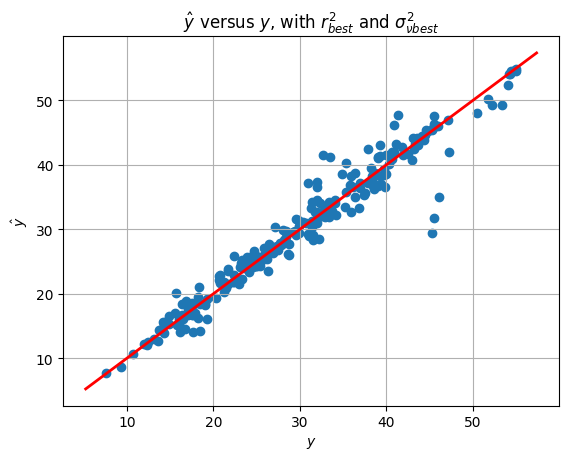

In [20]:
y_hat = y_hat_norm_r2s2 * sy + my
y_va = y_va_norm * sy + my
plt.figure()
plt.scatter(y_va, y_hat)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$, with $r_{best}^2$ and $\\sigma_{\\nu best}^2$')
plt.grid()
plt.show()

In [21]:
# Grid search for N
N_range = [2, 50]
N_values = np.arange(N_range[0], N_range[1], 1, dtype=int)
errors_N = np.empty(len(N_values))
y_hat_norm_N = np.empty(Nva)
for i in range(len(N_values)):
    N = N_values[i]
    y_hat_norm_N = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm,
                       X_te=X_va_norm, y_te=y_va_norm,
                       r2=r2_best, s2=s2_best, N=N)['y_hat']
    errors_N[i] = e_MSE(y_va_norm, y_hat_norm_N)
N_best = N_values[np.argmin(errors_N)]
print(f'Best N found (e_MSE = {min(errors_N)}): {N_best}')

Best N found (e_MSE = 0.045815634660468306): 21


In [22]:
# Result with best r2, s2 and N
y_hat_norm_best = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm,
                      X_te=X_va_norm, y_te=y_va_norm,
                      r2=r2_best, s2=s2_best, N=N_best)['y_hat']
print(f'e_MSE: {e_MSE(y_hat_norm_best, y_va_norm)}')

e_MSE: 0.045815634660468306


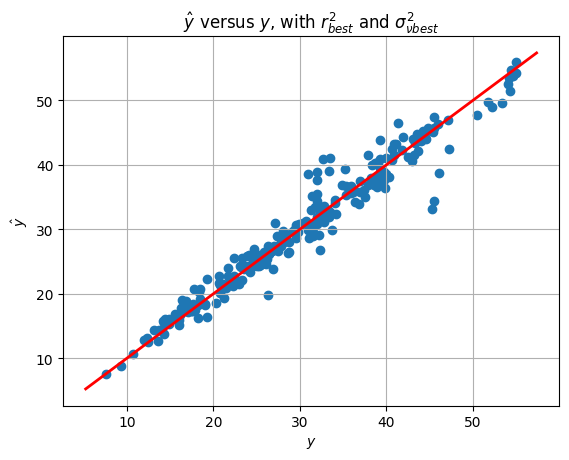

In [23]:
y_hat = y_hat_norm_best * sy + my
y_va = y_va_norm * sy + my
plt.figure()
plt.scatter(y_va, y_hat)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$, with $r_{best}^2$ and $\\sigma_{\\nu best}^2$')
plt.grid()
plt.show()

Test section

In [24]:
print(f'r2 = {r2_best}')
print(f's2 = {s2_best}')
print(f'N = {N_best}')

# GPR results
GPR_va = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm,
             X_te=X_va_norm, y_te=y_va_norm,
             r2=r2_best, s2=s2_best, N=N_best)
GPR_te = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm,
             X_te=X_te_norm, y_te=y_te_norm,
             r2=r2_best, s2=s2_best, N=N_best)

# De-normalization
y_va_hat = GPR_va['y_hat'] * sy + my
y_va = y_va_norm * sy + my

y_te_hat = GPR_te['y_hat'] * sy + my
y_te = y_te_norm * sy + my

r2 = 90.0
s2 = 0.0011
N = 21


In [25]:
# Validation set measurements
mean_va = np.mean(y_va_hat, axis=0)
var_va = np.var(y_va_hat, axis=0)
std_va = np.std(y_va_hat, axis=0)
MSE_va = e_MSE(y_va, y_va_hat)
corr_coeff_va = np.mean((y_va - mean_va) * (y_va_hat - y_va_hat.mean())) / (y_va.std() * y_va_hat.std())
R2_va = 1 - MSE_va / var_va

In [26]:
# Test set measurements
mean_te = np.mean(y_te_hat, axis=0)
var_te = np.var(y_te_hat, axis=0)
std_te = np.std(y_te_hat, axis=0)
MSE_te = e_MSE(y_te, y_te_hat)
corr_coeff_te = np.mean((y_te - mean_te) * (y_te_hat - y_te_hat.mean())) / (y_te.std() * y_te_hat.std())
R2_te = 1 - MSE_te / var_te

In [27]:
# Preparing result dataset
rows = ['Validation', 'Test']
cols = ['mean', 'std', 'MSE', 'correlation coefficient', 'R^2']
p = np.array([
    [mean_va, std_va, MSE_va, corr_coeff_va, R2_va],
    [mean_te, std_te, MSE_te, corr_coeff_te, R2_te]
])
results = pd.DataFrame(p, columns=cols, index=rows)
print(results)

                 mean        std       MSE  correlation coefficient       R^2
Validation  30.299930  10.199665  5.083990                 0.976361  0.951131
Test        28.625255  10.730864  5.059089                 0.979967  0.956066


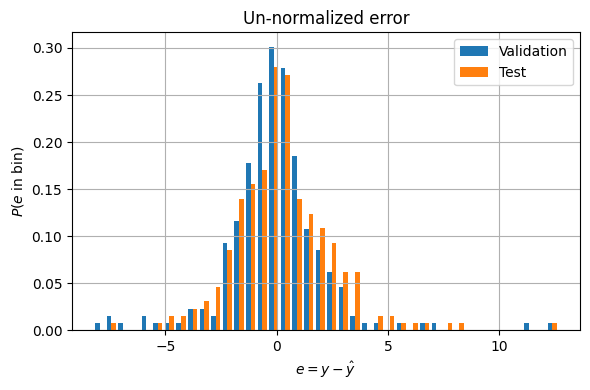

In [28]:
# Histogram of the un-normalized error
err_va = y_va - y_va_hat
err_te = y_te - y_te_hat
e = [err_va, err_te]
plt.figure(figsize=(6, 4))
plt.hist(e, bins=40, density=True, histtype='bar')
label = ['Validation', 'Test']
plt.xlabel(r'$e=y-\^y$')
plt.ylabel(r'$P(e$ in bin$)$')
plt.legend(label)
plt.grid()
plt.title('Un-normalized error')
plt.tight_layout()
plt.show()

28.34213990189002


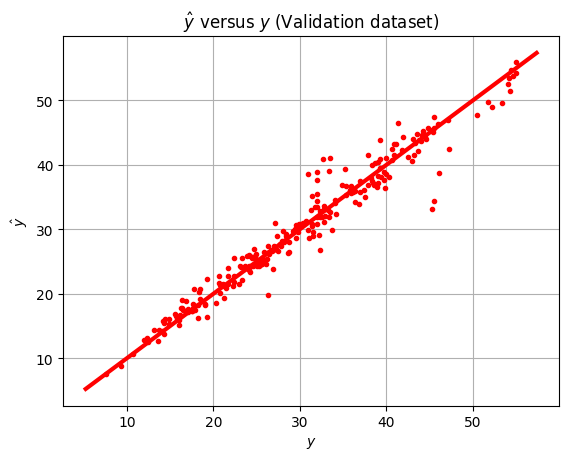

In [56]:
sigma = GPR_va['variance'] * sy + my
print(sigma)
plt.figure()
# plt.scatter(y_va, y_hat)
# plt.errorbar(y_va, y_va_hat, fmt='none', yerr=np.abs(sigma))
plt.plot(y_va, y_va_hat, 'r.')
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=3)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$ (Validation dataset)')
plt.grid()
plt.show()